# The finite Gaussian Process Distribution of Relaxation Times (fGP-DRT)

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sin, cos, pi, log, sqrt
import finite_GP_DRT
from scipy.optimize import minimize
import importlib
importlib.reload(finite_GP_DRT)
import os
from matplotlib import gridspec
import torch
import scipy.io
%matplotlib inline

## 1) Experimental data from $\rm Sr_{0.9}Ce_{0.1}Fe_{0.8}Ni_{0.2}O_{3-\delta}$-based symmetric cells at $500^{\circ}\rm C$ and with AIR-$3\%\rm H_2O$

### Load the data

In [74]:
df = pd.read_csv('./experimental_data/500-AIR-3H2O.csv')
##
N_freqs = df.shape[0]
freq_vec = np.flip(df['Freq'].values)
Z_exp = np.flip(df['Re'].values + 1j*df['Im'].values)
##
Z_exp_re = Z_exp.real
Z_exp_im = Z_exp.imag

### Define the range of log timescales

In [75]:
# define tau range (as in previous papers tau=1/f)
N_taus = 43
log_tau_min = -6  
log_tau_max = 2   

tau_vec = np.logspace(log_tau_min, log_tau_max, num = N_taus, endpoint=True)
log_tau_vec = np.log(tau_vec)

We define $\mathbf Z_{\rm re-im} = \begin{pmatrix}
 \mathbf{Z}_{\rm re} \\
 \mathbf{Z}_{\rm im} 
\end{pmatrix}$

In [76]:
Z_exp_re_im = np.zeros(2*N_freqs)
Z_exp_re_im[:N_freqs] = Z_exp.real
Z_exp_re_im[N_freqs:] = Z_exp.imag

## 2) Nyquist plot of SCFN impedance 

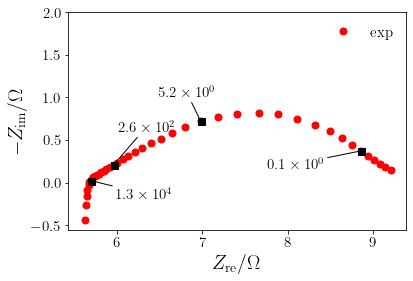

In [77]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# Nyquist plot of the impedance
plt.plot(np.real(Z_exp), -np.imag(Z_exp), 'o', markersize=7, color='red', label='exp')
plt.plot(np.real(Z_exp[5:40:10]), -np.imag(Z_exp[5:40:10]), 's', markersize=7, color='black')
plt.legend(frameon=False, fontsize = 15)
plt.axis('scaled')
plt.ylim(-0.55,2.0)

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)

fig = plt.gcf()
fig.set_size_inches(6.472, 4)
# label the frequencies - if you wish to use your own data you may need to modify this
label_index = range(5,40,10)
#
move = [[-1.1, -0.2], [-0.5, 0.3], [0.05, 0.4], [0.3, -0.2]]
for k, ind in enumerate(label_index):
    power = int(np.log10(freq_vec[ind]))
    num = freq_vec[ind]/(10**(power))
    plt.annotate(r'${0:.1f}\times 10^{1}$'.format(num, power), xy=(np.real(Z_exp[ind]), -np.imag(Z_exp[ind])), 
                 xytext=(np.real(Z_exp[ind])+move[k][0], move[k][1]-np.imag(Z_exp[ind])), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
#
plt.show()

### 2.1) Compute the matrix $\mathbf A$
As the nodal points $\log \tau$ are set we can defined once and for all
$$\mathbf A := \begin{pmatrix}
0 & \mathbf 1 & \mathbf A_{\rm re} \\
\boldsymbol \omega & 0 & \mathbf A_{\rm im}
\end{pmatrix}$$
where $\mathbf 1 \in \mathbb R^{N_f\times 1}$ and $\boldsymbol \omega = 2\pi \mathbf f$ with $\mathbf f = \left(f_1,f_2, \ldots, f_M\right)^\top$ being the experimental frequencies.

In [78]:
# compute A_re and A_im
A_re = finite_GP_DRT.compute_A_re(freq_vec, tau_vec)
A_im = finite_GP_DRT.compute_A_im(freq_vec, tau_vec)

# matrix A
A = np.zeros((2*N_freqs, N_taus+2))
# real part
A[:N_freqs, 1] = 1.0 
A[:N_freqs, 2:] = A_re
# imaginary part
A[N_freqs:, 0] = 2*pi*freq_vec*1E-4 # above note normalization by 1E-4
A[N_freqs:, 2:] = A_im

### 2.2) Selection of the optimal hyperparameters of the unconstrained GP-DRT model by minimizing the negative marginal log-likelihood (NMLL)

The values of the hyperparameter vector $\boldsymbol{\theta}$ were obtained by maximizing the experimental evidence, i.e., by maximizing the probability $p(\mathbf{Z} = \mathbf{Z}_{\rm exp}|\mathbf{x}, \boldsymbol \theta)$   of the experiment under no constraint on $\mathbf{x}$.

$$
\log\left(\mathbf{Z} = \mathbf{Z}_{\rm exp}|\mathbf x, \boldsymbol\theta\right) = - \frac{1}{2} \mathbf{Z}_{\rm exp}^\top \mathbf (A\boldsymbol{\Gamma}A^{\top} + \sigma_{n}^{2}\mathbf{I})^{-1}\mathbf{Z}_{\rm exp} -\frac{1}{2} \log(|A\boldsymbol{\Gamma}A^{\top} + \sigma_{n}^{2}\mathbf{I}|) - \frac{N+2}{2} \log \left( 2\pi\right)
$$
In the actual implementation
$$
L(\boldsymbol{\theta}) = -\log\left(\mathbf{Z} = \mathbf{Z}_{\rm exp}|\mathbf x, \boldsymbol\theta\right)-\frac{N+2}{2} \log \left( 2\pi\right)
$$

The above minimization problem is solved using the `optimize` function from `scipy`.

#### 2.2.1) Initialization of the parameters for the NMLL minimization

In [79]:
# initial parameters to maximize the marginal log-likelihood
sigma_n = 2.1  
sigma_L = 0.1   
sigma_R = 1.1   
sigma_f = 0.1   
ell =  1.2      

theta_0 = np.array([sigma_n, sigma_L, sigma_R, sigma_f, ell])

#### 2.2.2) NMLL optimization

In [80]:
seq_theta = np.copy(theta_0)
def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('{0:.7f}  {1:.7f}  {2:.7f}  {3:.7f}  {4:.7f}'.format(theta[0], theta[1], theta[2], theta[3], theta[4]))

print('sigma_n,   sigma_L,   sigma_R,   sigma_f,   ell')

# minimize the NMLL L(\theta) w.r.t sigma_n, sigma_R, sigma_f, and ell
res = minimize(finite_GP_DRT.NMLL_L_fct, theta_0, args=(A, Z_exp_re_im, N_freqs, log_tau_vec), method='L-BFGS-B', \
                callback=print_results, options={'disp': True})

# collect the optimized parameters
sigma_n, sigma_L, sigma_R, sigma_f, ell = res.x

sigma_n,   sigma_L,   sigma_R,   sigma_f,   ell
1.6841022  -0.0135816  1.3444861  0.9678448  1.2346444
0.0320171  0.4135176  1.7505754  1.6912832  1.2544120
0.0071598  0.4137713  1.7543264  1.7020650  1.2549003
0.0078631  0.4142159  1.7535239  1.6991066  1.2547917
0.0076149  0.4189581  1.7462514  1.6715537  1.2537350
0.0067361  0.4702250  1.6673317  1.3727429  1.2422903
0.0065069  0.5271598  1.5795620  1.0405230  1.2295647
0.0064329  0.6091227  1.4531668  0.5621332  1.2112400
0.0065172  0.6352638  1.4128373  0.4095033  1.2053941
0.0066457  0.6530710  1.3853538  0.3055106  1.2014029
0.0098270  0.5943455  1.4552590  0.2926943  1.4650531
0.0094216  0.6032543  1.4437794  0.2794134  1.4357994
0.0086988  0.6048725  1.4441880  0.3189531  1.4010132
0.0089454  0.6025510  1.4458539  0.2993752  1.4248818
0.0091410  0.5898230  1.4592467  0.2629033  1.5059963
0.0092173  0.5655213  1.4884352  0.2558726  1.6164478
0.0089854  0.4974011  1.5742808  0.3031181  1.8764659
0.0085723  0.4769888  1.6024477  

In [81]:
# show optimal hyperparameters
res.x

array([8.71370198e-03, 5.38898139e-03, 5.64795604e+00, 3.33823474e-01,
       1.80003531e+00])

### 2.3) Definition of the covariance matrix $\mathbf K$ with the optimized $\boldsymbol \theta$

In [82]:
# compute the matrix K
K = finite_GP_DRT.compute_K(log_tau_vec, sigma_f, ell)

### 2.4) Building the augmented covariance matrix $\boldsymbol{\Gamma}$

$$\mathbf \Gamma := \begin{pmatrix}
\mathbf \sigma_L^2 & 0 & 0 \\
0 & \mathbf \sigma_R^2 & 0\\
0 & 0 & \mathbf K
\end{pmatrix}$$

In [83]:
# compute the matrix Gamma
Gamma = np.zeros((N_taus+2, N_taus+2))
Gamma[0,0] = sigma_L**2
Gamma[1,1] = sigma_R**2
Gamma[2:, 2:] = K

### 2.5) Definition of $\mathbf \Psi$ and $\mathbf \Xi$

$$\mathbf \Psi = \mathbf A \mathbf \Gamma \mathbf A^\top + \sigma_n^2 \mathbf I$$ 
and 

$$\mathbf \Xi = \mathbf \Gamma \mathbf A^\top$$

In [84]:
# put together the matrix Gamma
Psi = A@(Gamma@A.T)+(sigma_n**2)*np.eye(2*N_freqs)
Psi = 0.5*(Psi + Psi.T) # symmetrize
Xi = Gamma@A.T

### 2.6) Factorization of the matrices and solving of the unconstrained problem
We are computing
$$
\mathbf x|\mathbf Z=Z_{\rm exp}\sim \mathcal N\left( \boldsymbol \mu_{x|Z}, \boldsymbol \Sigma_{x|Z} \right)
$$

using 
$$
\begin{align}
\boldsymbol \mu_{x|Z} &= \mathbf \Xi \mathbf \Psi^{-1}\mathbf Z_{\rm exp} \\
\boldsymbol \Sigma_{x|Z} &= \mathbf \Gamma - \mathbf \Xi \mathbf \Psi^{-1} \mathbf \Xi^\top
\end{align}
$$

The key step is to do Cholesky factorization of $\mathbf \Psi^{-1}$

In [85]:
# Cholesky factorization L of Psi -L is a lower-triangular matrix-
L = np.linalg.cholesky(Psi)

# solve for alpha
alpha = np.linalg.solve(L, Z_exp_re_im)
alpha = np.linalg.solve(L.T, alpha)

# obtain mu_x
mu_x_given_Z = np.dot(Xi, alpha)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_Psi = np.dot(inv_L.T, inv_L)

# estimate the covariance matrix of gamma for eq (21b)
Sigma_x_given_Z = Gamma - Xi@(inv_Psi@Xi.T)

# useful definition for plots
R_inf_unc = mu_x_given_Z[0]
cov_R_inf_unc = Sigma_x_given_Z[0, 0]

gamma_GP_unc = mu_x_given_Z[2:]
Sigma_GP_unc = Sigma_x_given_Z[2:, 2:]

### 2.7)  Sample of the DRT under positivity constraint

We now sample
$$
\mathbf x|\mathbf Z=Z_{\rm exp}\sim {\mathcal TN}\left( \boldsymbol \mu_{x|Z}, \boldsymbol \Sigma_{x|Z}, \mathbf 0, \infty \right)
$$

In [86]:
# inputs to the Hamilton Monte-Carlo sampler
# F*X+g >0
F = np.eye(N_taus+2) 
g = np.zeros(N_taus+2) # np.finfo(float).eps*np.ones(N_taus)
# covariance & mean
M = Sigma_x_given_Z + 1E-8*np.eye(N_taus+2)
mu_r = mu_x_given_Z
# initial val
initial_x_given_Z = np.abs(mu_x_given_Z)
samples_raw = finite_GP_DRT.generate_tmg(F, g, M, mu_r, initial_x_given_Z, cov=True, L=10000)

Current sample number 1000 / 10000
Current sample number 2000 / 10000
Current sample number 3000 / 10000
Current sample number 4000 / 10000
Current sample number 5000 / 10000
Current sample number 6000 / 10000
Current sample number 7000 / 10000
Current sample number 8000 / 10000
Current sample number 9000 / 10000
Current sample number 10000 / 10000


In [87]:
# postprocessing
samples = samples_raw[:,1000:] # remove burn in
samples_gamma = samples[2:,:] # slice out only samples of gamma
samples_Z_re_im = A@samples # samples of Z_re_im

### 2.8)  Plot of the constrained DRT

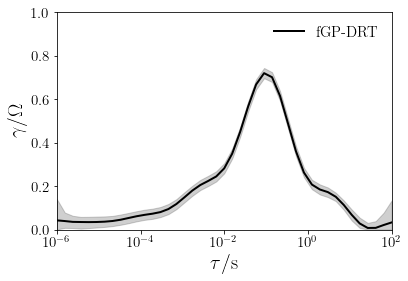

In [88]:
gamma_avg = np.average(samples_gamma,axis=1)
gamma_std = np.std(samples_gamma,axis=1)
gamma_median = np.nanmedian(samples_gamma,axis=1)
gamma_percentile_0dot1 = np.percentile(samples_gamma, 1, axis=1)
gamma_percentile_0dot5 = np.percentile(samples_gamma, 50, axis=1)
gamma_percentile_0dot9 = np.percentile(samples_gamma, 99, axis=1)

# plot the DRT and its confidence region
plt.semilogx(tau_vec, gamma_median, linewidth=2, color='black', label='fGP-DRT')
plt.fill_between(tau_vec, gamma_percentile_0dot1, gamma_percentile_0dot9, 
                 color='0.25', alpha=0.25)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-6, 1E2, 0 ,1.0])
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$\tau/\rm s$', fontsize = 20)
plt.ylabel(r'$\gamma/\Omega$', fontsize = 20)
fig.set_size_inches(6.472, 4)

plt.show()


### 2.9)  Plot of the impedance

In [89]:
Z_re_im_avg = np.average(samples_Z_re_im,axis=1)
Z_re_im_std = np.std(samples_Z_re_im,axis=1)
Z_re_im_median = np.nanmedian(samples_Z_re_im,axis=1)
Z_re_im_percentile_0dot1 = np.percentile(samples_Z_re_im, 1, axis=1)
Z_re_im_percentile_0dot5 = np.percentile(samples_Z_re_im, 50, axis=1)
Z_re_im_percentile_0dot9 = np.percentile(samples_Z_re_im, 99, axis=1)

Z_re_median = Z_re_im_median[:N_freqs]
Z_im_median = Z_re_im_median[N_freqs:]

Z_re_percentile_0dot1 = Z_re_im_percentile_0dot1[:N_freqs]
Z_re_percentile_0dot9 = Z_re_im_percentile_0dot9[:N_freqs]
Z_im_percentile_0dot1 = Z_re_im_percentile_0dot1[N_freqs:]
Z_im_percentile_0dot9 = Z_re_im_percentile_0dot9[N_freqs:]

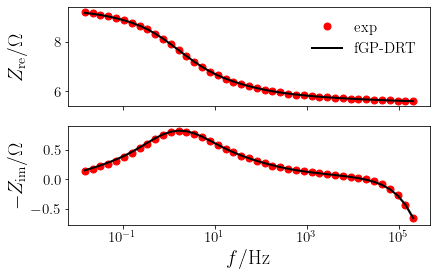

In [90]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

ax1.semilogx(freq_vec, Z_exp.real, 'o', markersize=7, color='red', label='exp')
ax1.semilogx(freq_vec, Z_re_median, linewidth=2, color='black', label='fGP-DRT')
ax1.fill_between(freq_vec, Z_re_percentile_0dot1, Z_re_percentile_0dot9, 
                 color='0.25', alpha=0.25)
ax1.set_ylabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)

ax1.legend(frameon=False, fontsize = 15)


ax2.semilogx(freq_vec, -Z_exp.imag, 'o', markersize=7, color='red', label='exp')
ax2.semilogx(freq_vec, -Z_im_median, linewidth=2, color='black', label='fGP-DRT')
ax2.fill_between(freq_vec, -Z_im_percentile_0dot1, -Z_im_percentile_0dot9, 
                 color='0.25', alpha=0.25)
ax2.set_ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
fig.set_size_inches(6.472, 4)

fig.align_ylabels()

plt.show()

## 3) Comparison of the fGP-DRT model with an ECM consisting of two ZARCs

#### Load ECM parameters for the SCFN at $500^{\circ} \rm C$ and with AIR-$3\%\rm H_2O$

In [91]:
param_ECM_500H2O = scipy.io.loadmat('ECM_parameter/SCFN_500-AIR-3H2O_DATA.mat')
print(param_ECM_500H2O)
data = param_ECM_500H2O['param_value']
        
Rinf = data[0]
R1 = data[1]
R2 = data[2]
tau1 = data[3]
tau2 = data[4]
phi_1 = data[5]
phi_2 = data[6]
L = data[7]       

Z_exp_ECM_1 = Rinf + 1j*2.*pi*freq_vec*L + R1/(1+(1j*2.*pi*freq_vec*tau1)**phi_1) + R2/(1+(1j*2.*pi*freq_vec*tau2)**phi_2)
gamma_exact_1 = (R1)/(2.*pi)*sin((1.-phi_1)*pi)/(np.cosh(phi_1*np.log(tau_vec/tau1))-cos((1.-phi_1)*pi))
gamma_exact_2 = (R2)/(2.*pi)*sin((1.-phi_2)*pi)/(np.cosh(phi_2*np.log(tau_vec/tau2))-cos((1.-phi_2)*pi))
gamma_ECM_1 = (gamma_exact_1 +gamma_exact_2).reshape(N_taus)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Jul 26 09:34:42 2021', '__version__': '1.0', '__globals__': [], 'param_value': array([[5.56745541e+00],
       [2.39721210e+00],
       [1.39137953e+00],
       [1.02233155e-01],
       [1.53693045e-02],
       [6.41319112e-01],
       [3.22551573e-01],
       [5.38622065e-07]])}


### 3.1) Nyquist plot compares the recovered impedance from the fGP-DRT model and from the ECM
### Figure 11(a) in fGP-DRT paper

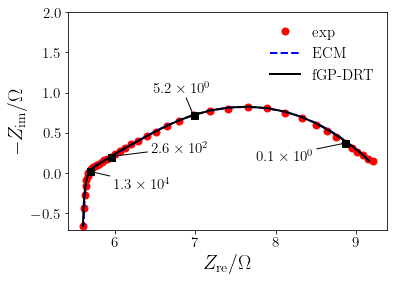

In [92]:
# plot of the impedance
plt.plot(Z_exp.real, -Z_exp.imag, "o", markersize=7, color="red", label='exp')
plt.plot(np.real(Z_exp_ECM_1), -np.imag(Z_exp_ECM_1),'--',  linewidth=2, color="blue", label='ECM')
plt.plot(Z_re_median, -Z_im_median, linewidth=2, color="black", label='fGP-DRT')
plt.plot(np.real(Z_exp[5:40:10]), -np.imag(Z_exp[5:40:10]), 's', markersize=7, color='black')

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.legend(frameon=False, fontsize = 15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.ylim(-0.7,2)
plt.legend(frameon=False, fontsize = 15)
plt.gca().set_aspect('equal', adjustable='box')
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)

label_index = range(5,40,10)
move = [[-1.1, -0.2], [-0.5, 0.3], [0.5, 0.06], [0.3, -0.2]]
for k, ind in enumerate(label_index):
    power = int(np.log10(freq_vec[ind]))
    num = freq_vec[ind]/(10**(power))
    plt.annotate(r'${0:.1f}\times 10^{1}$'.format(num, power), xy=(Z_exp_re[ind],-Z_exp_im[ind]), 
                 xytext=(np.real(Z_exp_re[ind])+move[k][0], move[k][1]-Z_exp_im[ind]), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))

plt.show()

### 3.2) Comparison of the DRT from the fGP-DRT model and from the ECM

### Figure 11(c)

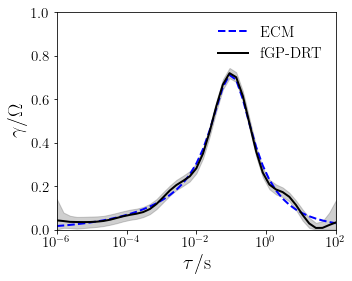

In [93]:
plt.semilogx(tau_vec, gamma_ECM_1,'--', linewidth=2, color="blue", label='ECM')
plt.semilogx(tau_vec, gamma_median, linewidth=2, color='black', label='fGP-DRT')
plt.fill_between(tau_vec, gamma_percentile_0dot1, gamma_percentile_0dot9, 
                 color='0.25', alpha=0.25)
      
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.xlim(1E-6, 1E2)
plt.ylim(0, 1.0)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.legend(frameon=False, fontsize = 15, loc= 'upper right')
plt.xlabel(r'$\tau/\rm s$', fontsize=20)
plt.ylabel(r'$\gamma/\Omega$', fontsize=20)
fig = plt.gcf()

fig.set_size_inches(5, 4)

plt.show()

### 3.3) Bode plots to compare the impedance from the fGP-DRT model and from the ECM
### Figure 11(e)

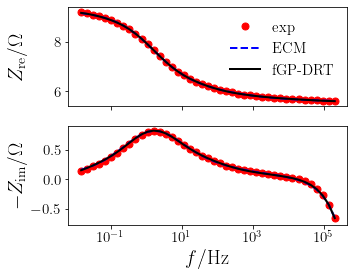

In [94]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.semilogx(freq_vec,Z_exp.real, 'o', markersize=7, color='red', label='exp')
ax1.semilogx(freq_vec, np.real(Z_exp_ECM_1),'--', linewidth=2, color='blue', label='ECM')
ax1.semilogx(freq_vec,Z_re_median, linewidth=2, color='black', label='fGP-DRT')
ax1.fill_between(freq_vec, Z_re_percentile_0dot1, Z_re_percentile_0dot9, 
                 color='0.25', alpha=0.25)

ax1.set_ylabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)

ax1.legend(frameon=False, fontsize = 15)

ax2.semilogx(freq_vec, -Z_exp.imag, 'o', markersize=7, color='red', label='exp')
ax2.semilogx(freq_vec,-np.imag(Z_exp_ECM_1),'--', linewidth=2, color='blue', label='ECM')
ax2.semilogx(freq_vec, -Z_im_median, linewidth=2, color='black', label='fGP-DRT')
ax2.fill_between(freq_vec, -Z_im_percentile_0dot1, -Z_im_percentile_0dot9, 
                 color='0.25', alpha=0.25)
ax2.set_ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
fig.set_size_inches(6.472, 4)

fig.align_ylabels()
fig.set_size_inches(5, 4)

plt.show()